## Creating the tools

In [14]:
##tools
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper 

In [15]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500) # type: ignore
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")

# print(arxiv.name)
arxiv.invoke("Attention is all you need")

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500) # type: ignore
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

# print(arxiv.name)
arxiv.invoke("Attention is all you need")

# print(wiki.name)

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [26]:
import os
from dotenv import load_dotenv
load_dotenv()

tavily_key = os.getenv("TAVILY_API_KEY")
groq_key = os.getenv("GROQ_API_KEY")

In [ ]:
## Creating Tavily search tool
from langchain_tavily import TavilySearch

tavily = TavilySearch()
tavily.invoke("Provide me the recent AI news")

{'query': 'Provide me the recent AI news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'AI News | Latest Headlines and Developments | Reuters',
   'url': 'https://www.reuters.com/technology/artificial-intelligence/',
   'content': 'The S&P 500 and the Nasdaq Composite hit all-time highs on Friday as renewed AI enthusiasm and the prospect of a looser monetary policy powered a recovery in U.S. stocks from months-long rout.',
   'score': 0.5931622,
   'raw_content': None},
  {'title': 'Artificial intelligence news: Chat AI, ChatGPT, AI generator, AI ...',
   'url': 'https://www.nbcnews.com/artificial-intelligence',
   'content': "The latest news and top stories on artificial intelligence, including AI chatbots like Microsoft's ChatGPT, Apple's AI Chatbot and Google's Bard.",
   'score': 0.5775198,
   'raw_content': None},
  {'title': 'Artificial Intelligence News -- ScienceDaily',
   'url': 'https://www.sciencedaily.com/news/computers_math/artifici

In [ ]:
#Combing the tools to integrate with the LLM
tools = [arxiv, wiki, tavily]

#Intialize the LLM model
from langchain_groq import ChatGroq

llm = ChatGroq(model = "qwen-qwq-32b")

# llm.invoke("What is AI")

AIMessage(content='\n<think>\nOkay, the user is asking, "What is AI?" Let me start by breaking down the term. AI stands for Artificial Intelligence. I need to explain it in simple terms. Maybe start with a definition: AI refers to the simulation of human intelligence in machines. But wait, that\'s a bit vague. Let me elaborate.\n\nHmm, I should mention that AI involves tasks like learning, reasoning, and problem-solving. Maybe categorize AI into types to make it clearer. There\'s narrow or weak AI, which is designed for specific tasks, like voice assistants or recommendation systems. Then there\'s general or strong AI, which is more hypothetical, aiming for human-like intelligence. Oh, right, there\'s also the distinction between machine learning, deep learning, and neural networks. I should explain those briefly too.\n\nWait, the user might not know technical terms. Maybe start with examples. Like, when you use Siri or Alexa, that\'s AI. Or how Netflix recommends shows based on your v

In [ ]:
llm_with_tools = llm.bind_tools(tools=tools) 

# Execute the call
llm_with_tools.invoke("what is the latest news on AI")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest news on AI. I need to figure out which tool to use. The available functions are arxiv, wikipedia, and tavily_search. \n\nThe user wants the latest news, which suggests they need recent information. Arxiv is for academic papers, which might not be the best for the latest news. Wikipedia is for encyclopedic info, which also might not be timely. Tavily_search seems suitable because it can search the web and has parameters for time ranges.\n\nLooking at Tavily\'s parameters, there\'s a time_range option. Since the user specified "latest," I should set time_range to "day" or "week" to get recent articles. The topic should be "news" because they\'re asking about current events. Also, the search_depth could be "advanced" to ensure comprehensive results, but the default is "basic". However, since they want the latest, maybe "advanced" would be better to dig deeper. \n\nWait, the default for s

In [39]:
##Creating workflow for langGraph Application

#State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage #Human message or AI message
from typing import Annotated #Labeling
from langgraph.graph.message import add_messages #Reducers in Langgraph

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] #add_messages will append the messages as it is a reducer

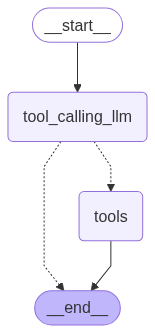

In [49]:
#Creating the chatbot with LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Node definition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

#build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#Adding edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              ##if the latest message from assistant is a tool call ---> tools_condition routes to tools
                              ##else if not a tool call --> tools_condition routes to END
                              tools_condition,
                              )
builder.add_edge("tools", END)

graph = builder.compile()

#Viewing the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
# Invoking the graph
messages = graph.invoke({"messages": "1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (7am6e3at0)
 Call ID: 7am6e3at0
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [51]:
messages = graph.invoke({"messages": "Hi How are you doing"})
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Hi How are you doing
================================== Ai Message ==================================

Hello! I'm an AI assistant here to help you. I'm doing well, thank you for asking! How can I assist you today?


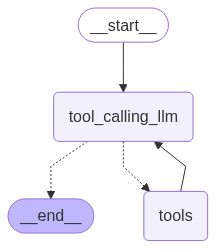

In [ ]:
#Creating the chatbot with LangGraph with ReAct Framework
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Node definition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

#build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#Adding edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              ##if the latest message from assistant is a tool call ---> tools_condition routes to tools
                              ##else if not a tool call --> tools_condition routes to END
                              tools_condition,
                              )
builder.add_edge("tools", "tool_calling_llm") #React framework is implemented over here

graph2 = builder.compile()

#Viewing the graph
display(Image(graph2.get_graph().draw_mermaid_png()))

In [56]:
messages = graph.invoke({"messages": "Hi How are you doing and please tell me recent research paper on AI"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi How are you doing and please tell me recent research paper on AI
================================== Ai Message ==================================
Tool Calls:
  arxiv (qc3z7d2zj)
 Call ID: qc3z7d2zj
  Args:
    query: AI
    time_range: month
================================= Tool Message =================================
Name: arxiv

Published: 2024-08-26
Title: AI Thinking: A framework for rethinking artificial intelligence in practice
Authors: Denis Newman-Griffis
Summary: Artificial intelligence is transforming the way we work with information
across disciplines and practical contexts. A growing range of disciplines are
now involved in studying, developing, and assessing the use of AI in practice,
but these disciplines often employ conflicting understandings of what AI is and
what is involved in its use. New, interdiscipl


In [57]:
messages = graph2.invoke({"messages": "Hi I am Shaun How are you doing and please tell me recent research paper on AI"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi I am Shaun How are you doing and please tell me recent research paper on AI
================================== Ai Message ==================================
Tool Calls:
  arxiv (k5zegxtrd)
 Call ID: k5zegxtrd
  Args:
    query: recent AI research papers
================================= Tool Message =================================
Name: arxiv

Published: 2021-03-29
Title: "Weak AI" is Likely to Never Become "Strong AI", So What is its Greatest Value for us?
Authors: Bin Liu
Summary: AI has surpassed humans across a variety of tasks such as image
classification, playing games (e.g., go, "Starcraft" and poker), and protein
structure prediction. However, at the same time, AI is also bearing serious
controversies. Many researchers argue that little substantial progress has been
made for AI in recent decades. In this paper, the author (1) 
================================== Ai Message ====================